In [1]:
%%capture output
%pip install numpy
%pip install matplotlib

The description of the 2d problem is very limited, im going to assume we do weighted resampling, ans use the basically alg 1 of the other paper form green maskell

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def bivar_normal_p(sample, mean, covar):
    x_minus_mean = np.subtract(sample,mean)
    temp1 = np.dot(x_minus_mean.T,np.linalg.inv(covar))
    temp2 = np.dot(temp1,x_minus_mean)
    n = len(sample)
    k = (((2*np.pi)**(n/2))*((np.linalg.det(covar))**(1/2)))**-1
    return k*(np.e**(-0.5*temp2))

def target_dist_prob(sample):
    "returns how close a sample is to target dist"
    return bivar_normal_p(sample,[3,2],np.eye(2))

def initial_proposal_prob(sample):
    return bivar_normal_p(sample,[0,0],np.eye(2))

def initial_proposal(n):
    return np.random.randn(n,2)

def get_neff(weights):
    sum_w_squared = 0
    for w in weights:
        sum_w_squared +=  w**2
    return 1/sum_w_squared

def optimal_l_kernel():
    return

def forward_proposal_l_kernel():
    return

def forward_proposal_prob(theta,theta_hat, covar):
    return bivar_normal_p(theta_hat,theta,covar)

def get_initial_weights(samples):
    return [target_dist_prob(s)/initial_proposal_prob(s) for s in samples]

def normalise_weights(weights):
    return weights/sum(weights)

def get_lk(weights):
    weights_squared = np.multiply(weights,weights)
    return sum(weights)**2/sum(weights_squared)


def get_ck_opt_arr(weights_arr):
    ck = []
    for weights in weights_arr:
        ck.append(get_lk(weights))
    # normalise and return
    return ck/sum(ck)
        

def get_y_guess_with_ck(samples_arr,weights_arr)->list[float]:
    estimate = [0,0]
    ck_arr = get_ck_opt_arr(weights_arr)
    for samples, weights, ck in zip(samples_arr,weights_arr,ck_arr):
        for sample,weight in zip(samples, weights):
            estimate += weight * sample * ck
    return estimate

def normal_y_guess(samples,weights):
    y1,y2 = 0,0
    for w,s in zip(weights, samples):
        s1,s2 = s
        y1+=w*s1
        y2+=w*s2
    return y1,y2


def reset_weights(n):
    return [1/n]*n          

def weighted_resample(samples,weights):
    index = np.arange(0,len(samples))
    sample_index = np.random.choice(index,len(index),p=weights)
    return [samples[si] for si in sample_index]

def forward_proposal(samples,covar_mat):
    samples = np.array(samples)
    var = covar_mat[0][0]
    return samples+np.random.randn(len(samples),len(samples[0]))*var

def new_weights_opt(weights, theta_arr, theta_hat_arr, covar):
    """gets the new weights using the optimal l kernel"""
    new_weights = []
    for w, theta, theta_hat in zip(weights,theta_arr, theta_hat_arr):
        targ_ratio = target_dist_prob(theta_hat)/target_dist_prob(theta)
        l_kern_proposal_ratio = 1 #optimal_l_kernel()/(forward_proposal_prob(theta,theta_hat,covar))
        new_weights.append(targ_ratio*l_kern_proposal_ratio*w)

    return new_weights


n = 500
t_total, t = 101, 1
samples, weights, y_guess = [], [], []
samples.append(initial_proposal(n))
weights.append(get_initial_weights(samples[-1]))
proposal_covar_mat = np.eye(2)
resample_count = 0

while t<t_total:
    weights[-1] = normalise_weights(weights[-1])
    y_guess.append(get_y_guess_with_ck(samples,weights))
    neff = get_neff(weights[-1])
    if neff<(n/2):
        samples[-1] = weighted_resample(samples[-1], weights[-1])
        weights[-1] = reset_weights(n)
        resample_count+=1
    t += 1
    samples.append(forward_proposal(samples[-1],proposal_covar_mat))
    weights.append(new_weights_opt(weights[-1],samples[-2], samples[-1],proposal_covar_mat))

weights[-1] = normalise_weights(weights[-1])
print(f'the length of y_guess is: {len(y_guess)}')
print(f'the number of resamples was {resample_count}')

the length of y_guess is: 100
the number of resamples was 100


## Plotting y_guess for x1 x2

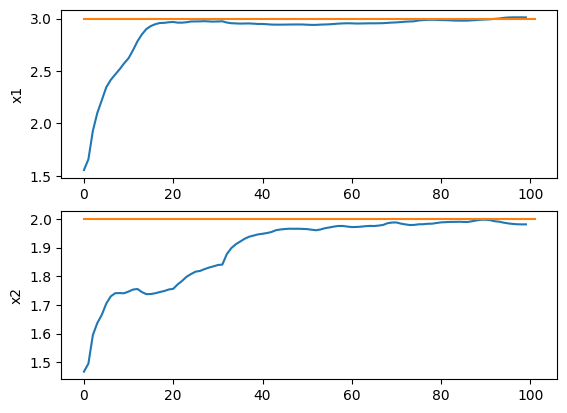

In [109]:
y_guess = np.array(y_guess)

fig, ax = plt.subplots(2)
ax[0].plot(y_guess[:,0])
ax[1].plot(y_guess[:,1])
ax[0].plot([0,t_total],[3,3])
ax[1].plot([0,t_total],[2,2])
ax[0].set_ylabel('x1')
ax[1].set_ylabel('x2')
plt.show()

read the paper, the number of samples were 500 not 100, now we resample every step which is preferable.

* working for non optimal l kernel although resampling doesn't occur every iteration unlike in the paper
* so possibly something is wrong with the maths of the resampling like maybe defensive sampling is used i could check their code i guess
* also its common for the alg to be 0.1 off of the actual value in y_guess with ckopt, maybe i should check this against a sliding window average bc my maths is probably wrong for ckopt
* also should check the bivar gaussian is written correctly and write the optimal l kernel part of the code which isn't done yet
* also i should make this so you can pass in the funciton name that you use for the l_kernel - optimal or suboptimal, would be nice to do them both in parallel, but probably easier to split them into two seperate loops and just reuse the functions